# Extracting 'syllables' 

In [1]:
import sys
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit/data_preprocessing_code')
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit')
import support_functions as sf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp
import bandit_preprocessing as bp
import sys
import os
%matplotlib inline 

## load in csv files (from running exportTrials.m)

### Mouse data

In [2]:
data90 = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/processed_data/full_9010_02192017.csv',index_col=0)
data80 = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/processed_data/full_8020_02192017.csv',index_col=0)
data70 = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/processed_data/full_7030_02192017.csv',index_col=0)

### HMM data

In [84]:
data90 = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/processed_data/hmm_matrix_full_9010.csv',index_col=0)
data80 = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/processed_data/hmm_matrix_full_8020.csv',index_col=0)
data70 = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/processed_data/hmm_matrix_full_7030.csv',index_col=0)

In [3]:
data90['Condition'] = '90-10'
data80['Condition'] = '80-20'
data70['Condition'] = '70-30'

In [4]:
data = data90.append(data80)
data = data.append(data70)

In [11]:
data.shape

(77487, 51)

# Looking at syllables

In [6]:
data.head(5)

,Mouse ID,Session ID,Block Trial,Port Streak,Reward Streak,10_Port,10_Reward,10_ITI,10_trialDuration,9_Port,...,1_Port,1_Reward,1_ITI,1_trialDuration,0_ITI,Decision,Switch,Higher p port,Reward,Condition
0,K1,11042016_K1,11.0,9.0,-1.0,0.0,0.0,15.781,1.542,1.0,...,1.0,0.0,1.346,0.674,1.087,1.0,0.0,1.0,1.0,90-10
1,K1,11042016_K1,12.0,10.0,1.0,1.0,1.0,3.252,0.880,1.0,...,1.0,1.0,1.087,0.574,1.584,1.0,0.0,1.0,1.0,90-10
2,K1,11042016_K1,13.0,10.0,2.0,1.0,1.0,1.294,0.805,1.0,...,1.0,1.0,1.584,0.646,5.985,1.0,0.0,1.0,1.0,90-10
3,K1,11042016_K1,14.0,10.0,3.0,1.0,1.0,2.992,0.787,1.0,...,1.0,1.0,5.985,0.552,1.062,1.0,0.0,1.0,1.0,90-10
4,K1,11042016_K1,15.0,10.0,4.0,1.0,1.0,1.058,0.689,1.0,...,1.0,1.0,1.062,0.664,1.122,1.0,0.0,1.0,0.0,90-10


# Syllables (including port)

In [167]:
columns = data.columns.values
combos = []
df_combos = pd.DataFrame(data = None,index=np.arange(0,data.shape[0]),columns=['Syllable','Decision','Mouse ID','Condition'])
for row in range(data.shape[0]):
    trial = data.iloc[row]
    c = np.zeros(10)

    for j,i in enumerate(np.arange(1,11)):
        i_str = str(i) + '_'
        matching = [s for s in columns if ((i_str in s) & ((('Port') in s) or ('Reward' in s)))]

        if (np.array_equal(trial[matching].values,[0,0])):
            c[j] = -1
        elif (np.array_equal(trial[matching].values,[1,0])):
            c[j] = -2
        elif (np.array_equal(trial[matching].values,[0,1])):
            c[j] = 1
        elif (np.array_equal(trial[matching].values,[1,1])):
            c[j] = 2

    c = np.flipud(c)
    
    df_combos.iloc[row]['Syllable'] = str(c)[1:-1]
    df_combos.iloc[row]['Decision'] = trial['Decision']
    df_combos.iloc[row]['Mouse ID'] = trial['Mouse ID']
    df_combos.iloc[row]['Condition'] = trial['Condition']

# Syllables (Reward only)

In [174]:
columns = data.columns.values
combos = []
df_combos = pd.DataFrame(data = None,index=np.arange(0,data.shape[0]),columns=['Syllable','Decision','Mouse ID','Condition'])
for row in range(data.shape[0]):
    trial = data.iloc[row]
    c = np.zeros(10)
    
    #only consider instances where the mouse has not switched in the past 5 trials
    if trial['Port Streak'] >= 5:
        for j,i in enumerate(np.arange(1,11)):
            i_str = str(i) + '_'

            matching = [s for s in columns if ((i_str in s) & ('Reward' in s))]

            c[j] = trial[matching].values

        c = np.flipud(c)

        df_combos.iloc[row]['Syllable'] = str(c)[1:-1]
        df_combos.iloc[row]['Decision'] = trial['Decision']
        df_combos.iloc[row]['Mouse ID'] = trial['Mouse ID']
        df_combos.iloc[row]['Condition'] = trial['Condition']


## Load in df_combos (if already computed -- it takes a while)

In [10]:
df_combos = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/syllables.csv',index_col=0)
df_combos.shape

(77487, 5)

## Add 'switch' parameter

In [193]:
df_combos['Switch'] = data['Switch'].values

## Add 'port streak' parameter

In [12]:
df_combos['Port Streak'] = data['Port Streak'].values

In [16]:
df = df_combos[df_combos['Port Streak'] >= 10].copy()

## Unique syllables

In [20]:
unique = np.unique(df['Syllable'].values)
unique.shape

(1009,)

In [18]:
u_switch = []
for u in unique:
    u_switch.append(df_combos[df_combos['Syllable'] == u]['Switch'].mean())

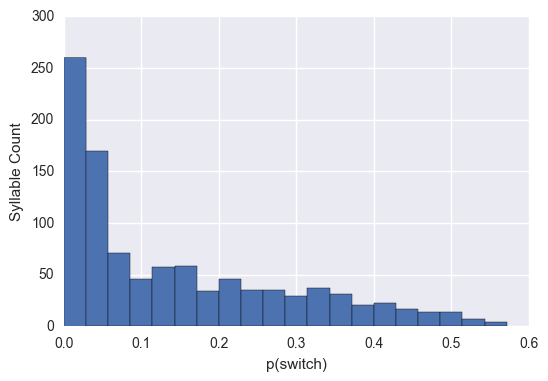

In [19]:
plt.hist(u_switch,bins=20)
plt.xlabel('p(switch)')
plt.ylabel('Syllable Count')

In [48]:
counts = df[df['Condition']=='70-30']['Syllable'].value_counts()
#counts.sort_values(ascending=False)
counts

 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.    270
 1.  1.  1.  1.  1.  1.  1.  1.  1.  0.    131
 1.  1.  1.  1.  1.  1.  1.  0.  1.  1.    125
 1.  0.  1.  1.  1.  1.  1.  1.  1.  1.    123
 1.  1.  1.  0.  1.  1.  1.  1.  1.  1.    123
 1.  1.  1.  1.  1.  1.  1.  1.  0.  1.    119
 1.  1.  1.  1.  1.  1.  0.  1.  1.  1.    117
 1.  1.  0.  1.  1.  1.  1.  1.  1.  1.    117
 1.  1.  1.  1.  1.  0.  1.  1.  1.  1.    115
 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.    113
 1.  1.  1.  1.  0.  1.  1.  1.  1.  1.    112
 1.  1.  1.  1.  1.  1.  1.  1.  0.  0.     71
 1.  1.  1.  1.  0.  1.  1.  1.  1.  0.     61
 0.  1.  1.  1.  0.  1.  1.  1.  1.  1.     61
 1.  0.  1.  1.  1.  0.  1.  1.  1.  1.     60
 1.  1.  1.  1.  1.  1.  0.  1.  1.  0.     60
 1.  1.  1.  0.  1.  1.  1.  1.  1.  0.     59
 1.  1.  1.  1.  1.  0.  0.  1.  1.  1.     56
 1.  1.  1.  1.  0.  1.  0.  1.  1.  1.     55
 1.  1.  1.  1.  1.  1.  1.  0.  0.  1.     55
 1.  1.  1.  0.  1.  1.  1.  1.  0.  1.     54
 1.  1.  0.  

## Save df_combos

In [227]:
df_combos.to_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/syllables.csv')

In [49]:
data[data['Switch']==1]['1_']

,Mouse ID,Session ID,Block Trial,Port Streak,Reward Streak,10_Port,10_Reward,10_ITI,10_trialDuration,9_Port,...,1_Port,1_Reward,1_ITI,1_trialDuration,0_ITI,Decision,Switch,Higher p port,Reward,Condition
0,K1,11042016_K1,11.0,9.0,-1.0,0.0,0.0,15.781,1.542,1.0,...,1.0,0.0,1.346,0.674,1.087,1.0,0.0,1.0,1.0,90-10
1,K1,11042016_K1,12.0,10.0,1.0,1.0,1.0,3.252,0.880,1.0,...,1.0,1.0,1.087,0.574,1.584,1.0,0.0,1.0,1.0,90-10
2,K1,11042016_K1,13.0,10.0,2.0,1.0,1.0,1.294,0.805,1.0,...,1.0,1.0,1.584,0.646,5.985,1.0,0.0,1.0,1.0,90-10
3,K1,11042016_K1,14.0,10.0,3.0,1.0,1.0,2.992,0.787,1.0,...,1.0,1.0,5.985,0.552,1.062,1.0,0.0,1.0,1.0,90-10
4,K1,11042016_K1,15.0,10.0,4.0,1.0,1.0,1.058,0.689,1.0,...,1.0,1.0,1.062,0.664,1.122,1.0,0.0,1.0,0.0,90-10
